## Questão 2 - 1ª Lista de Exercícios - Deep Learning

![Questão 1](imgs/questoes/q2.png "Questão 2")

In [166]:
import numpy as np
import math

def randomizeArrayData(arr, variation=0.1):
    """ 
    Adiciona uma variação aleatoria em uma array de floats 
    """
    
    for i in range(len(arr)):
        arr[i] = arr[i] + (np.random.random()-0.5)*variation
        
    return arr

def criaDataset(n, variation=0.1):
    """ 
    Cria um conjunto de exemplos para a questão 1. Classificação de arestas em um cubo 
    """
    
    X = []
    Y = []
    
    # Crie n/8 exemplos para cada classe
    for i in range(math.ceil(n/8)):
        X.append(randomizeArrayData([0, 0, 0], variation)) 
        Y.append(0)
        X.append(randomizeArrayData([0, 0, 1], variation)) 
        Y.append(1)
        X.append(randomizeArrayData([0, 1, 0], variation)) 
        Y.append(2)
        X.append(randomizeArrayData([0, 1, 1], variation)) 
        Y.append(3)
        X.append(randomizeArrayData([1, 0, 0], variation)) 
        Y.append(4)
        X.append(randomizeArrayData([1, 0, 1], variation)) 
        Y.append(5)
        X.append(randomizeArrayData([1, 1, 0], variation)) 
        Y.append(6)
        X.append(randomizeArrayData([1, 1, 1], variation)) 
        Y.append(7)
        
    return X, Y

print("Criação de um dataset com 16 pontos e variação de +/- 20%:\n")
display(criaDataset(16, 0.2))

Criação de um dataset com 16 pontos e variação de +/- 20%:



([[0.009346623008472355, 0.008485945791454763, 0.07275777851402017],
  [0.06021738909748882, 0.07283097971827728, 1.0246106386970841],
  [0.0576935460140221, 0.9080815325034474, 0.03309518697951035],
  [-0.06533747197901563, 1.070621046356418, 1.078160671735873],
  [0.939305523762139, -0.09947388665850361, -0.028089595878995444],
  [1.0216212581057265, 0.07331617901205774, 0.9918455527460391],
  [1.0770534295469099, 1.004845568449402, 0.017698879933827707],
  [1.0611779927146507, 0.9775318311263763, 0.9978247128109207],
  [0.03483868343498051, -0.09694920724109271, 0.0783650595560411],
  [0.04095717250891369, -0.011787909629753845, 0.9760120972697816],
  [-0.016024218469415485, 1.0434480903001067, 0.06876413100110526],
  [0.014572825730405525, 0.9836545018889202, 1.085405761618521],
  [1.0854028573273768, -0.07817874814976096, 0.001887540334089266],
  [1.0649238736288025, 0.0029690074560100536, 0.9806915733651271],
  [1.0305002414916178, 1.0939909913409709, 0.06219405469058619],
  [0.9

## Resolução

In [248]:
import pprint
import numpy as np
from viznet import connecta2a, connect121, node_sequence, NodeBrush, EdgeBrush, DynamicShow
import pickle
import pdb
pdb.set_trace = lambda: 1  # This solves a problem with the python debugger and the library viznet

class Neuron:
    """
    Class that represents a neuron inside the neural network
    """

    def __init__(self, inputs, activation='sigmoid'):   
        """
        Create a neuron object.
        Param:
            - inputs: THe number of inputs that this neuron will have.
            - activation: The name of the activation function
        """
        
        self.newWeights = np.zeros(inputs)
        self.weights = np.random.rand(inputs)
        self.bias = np.random.random()
        
        assert inputs > 0
        self.inputs = int(inputs)
        
        assert activation == 'sigmoid' or activation == 'tanh' or activation == 'relu' or activation == 'linear' or  activation == 'step'
        self.activation = activation

    def activation_function(self, func_type, value):
        """
        Most commons activation functions.
        Param: func_type - A tring with one of the valid values: sigmoid, tanh, relu, linear and step
                    value - Apply the function to the value
        Return: The result of the activation function
        """
        
        assert func_type == 'sigmoid' or func_type == 'tanh' or func_type == 'relu' or func_type == 'linear' or  func_type == 'step'
        
        if func_type == 'sigmoid':
            return 1 / (1 + np.exp(-value))
        elif func_type == 'tanh':
            return math.sinh(value) / math.cosh(value)
        elif func_type == 'relu':
            return 0 if (value < 0) else value
        elif func_type == 'linear':
            return value
        elif func_type == 'step':
            return 0 if (value < 0) else 1
    
    
    def adjustWeights(self):
        """
        Update the weigths with the pre-calculated newWeigths variable. This function is used during training.
        """
        self.weights = self.newWeights
        self.newWeights = np.zeros(len(self.weights))
        
    
    def foward(self, x, apply_activation=True, verbose=False):
        """
        Calculate the output of the neuron. 
        Param:
            - inputs: Array with the inputs signals
            - apply_activation: If true, Apply the activation final. If false, return the output without activation function (Vj)
            - verbose: If true, show some data on the stdout
        Return: The neuron output (with or without the activation function applied)
        """
        vj = np.dot(x, self.weights) + self.bias
        out = vj if (not apply_activation) else self.activation_function(self.activation , vj)
        
        if verbose:
            print("Input: ", x, " -> Vj: ", vj, " -> Output: ", out)
            
        return out
        
    def __repr__(self):
        """
        Alternative way to see the object as string
        """
        return pprint.pformat(vars(self), indent=0, width=1000, depth=None)


class NeuralNetwork:
    """
    Class that represents a Feed-foward Neural Network that can be trained using backpropagation.
    """
    
    def __init__(self, inputs=1, architecture=[1], lr=0.01, momentum=0, isClassification=False):
        """
        Create a feed-foward neural network object.
        Param:
            - inputs: The amount of inputs the network will have (scalar)
            - architecture: An array of numbers that represents the amount of neurons in each layer
            - lr: The learning rate
            - momentum: The momentum constant. Zero if we shall not momentum
            - isClassification: If true, use a int+round function that is applyed in the end of the calculation
        """
        
        # Make sure the architecture is a list and not empty
        assert isinstance(architecture, list) and len(architecture) > 0
        
        self.architecture = architecture        
        assert inputs > 0
        self.inputs = int(inputs)
        self.momentum = momentum if momentum > 0 else 0
        self.lr = lr if lr > 0 else 0.00001 # Make sure the LR is not too close to zero       
        self.isClassification = isClassification

        # Create the layers and neurons based on the architecture
        self.initLayers()
        
    def initLayers(self):
        """
        Initialize the layers and create the neurons
        """
        
        # The amount of inputs of each Neuron need to be the total of neurons of the previus layer OR self.inputs if this is the first layer
        totalInputs = self.inputs
        
        # Clear all layers (and weigths)
        self.layers = []
        
        # For each layer of the architecture
        for n in self.architecture:  
            
            # Start an array with the current layer
            currentLayer = []
            
            # Create n neurons 
            for count in range(n):
                currentLayer.append( Neuron(totalInputs, activation='relu'))
                
            totalInputs = n
            
            # Add the current layer to the layer list
            self.layers.append(currentLayer)                
     
    def evaluate(self, x=None, y=None):
        """
        Returns the loss value for each data.
        Param:
            x: The input samples data, as a Numpy array (or list of Numpy arrays).
            y: The target values
        Return: An array of loss values 
        """
        # TODO 
        return None    
        
        
    
    def predict(self, x, verbose=False):
        """
        Create the predictions for the input samples.
        Param:
            x: One input data
            verbose: If true, show some data on the stdout
        Return: the predicted value
        """

        # On the first layer, the input is the data row
        currentInputs = x

        currentOutputs = []

        # For each layer
        for l in range(len(self.layers)):
            currentOutputs = []
            
            currentLayer = self.layers[l]

            # For each neuron 
            for n in range(len(self.layers[l])):
                currentNeuron = self.layers[l][n]                    
                currentOutputs.append(currentNeuron.foward(currentInputs, apply_activation=True, verbose=verbose))

            # For the next layer, the input become the output of the preview layer
            currentInputs = currentOutputs
        
        # Apply the output filter if needed
        for i in range(len(currentOutputs)):
            currentOutputs[i] = currentOutputs[i] if not self.isClassification else int(round(currentOutputs[i]))
            
        return currentOutputs
    
    def save(self, file='neuralnet.pkl'):
        """
        Serialize the Neural Network to a file that can be loaded later.
        Param:
            file: The file path where the object will be saved
        """
        assert file != None
        with open(file, 'wb') as output:  # Overwrites any existing file.
            pickle.dump(self, output, pickle.HIGHEST_PROTOCOL)
            
    def load(self, file='neuralnet.pkl'):
        """
        Serialize the Neural Network to a file that can be loaded later.
        Param:
            file: The file path where the object will be saved
        Return: This object with the new architecture
        """
        assert file != None
        with open(file, 'rb') as input:
            tmp = pickle.load(input)
        self.__dict__.update(tmp.__dict__)
        
        return self
        
    def draw(self, file=None, size=(10,6)):
        """
        Draw the network architecture 
        Param:
            - file: The file where the image will be saved. Default: None
            - size: the image size. Default: (10,6)
        """
        
        with DynamicShow(size, filename=file) as d:
            
            num_hidden_layer = len(self.architecture) - 2
            token_list = ['\sigma^z'] + ['y^{(%s)}' % (i + 1) for i in range(num_hidden_layer)] + ['\psi']
            kind_list = ['nn.input'] + ['nn.hidden'] * num_hidden_layer + ['nn.output']
            radius_list = [0.1] + [0.2] * num_hidden_layer + [0.3]
            x_list = 1.5 * np.arange(len(self.architecture)) + 1.5

            seq_list = []
            
            # Input pins
            inputPins = NodeBrush('qc.C', d.ax)
            seq_list.append(node_sequence(inputPins, self.inputs, center=(0, 0), space=(0, 1)))
            
            # Network and connections
            for n, kind, radius, y in zip(self.architecture, kind_list, radius_list, x_list):
                b = NodeBrush(kind, d.ax)
                seq_list.append(node_sequence(b, n, center=(y, 0), space=(0, 1)))
            
            for st, et in zip(seq_list[:-1], seq_list[1:]):
                connecta2a(st, et, EdgeBrush('-->', d.ax))
            
            # Output pins
            outputEdge = EdgeBrush('---', d.ax)
            outputPins = NodeBrush('qc.C', d.ax)
            seq_list.append(node_sequence(outputPins, self.architecture[-1], center=(x_list[-1]+1.5, 0), space=(0, 1)))            
            connect121( seq_list[-2], seq_list[-1], outputEdge)                
                    
    def __repr__(self):
        """
        Alternative way to see the object as string
        """
        return pprint.pformat(vars(self), indent=1, width=1, depth=5)
    
    def fit(self, x=None, y=None, batch_size=None, epochs=1, verbose=True, validation_split=0.1, shuffle=True):
        """
        Train the Neural Network
        Param:
            x: The input samples data, as a Numpy array (or list of Numpy arrays).
        Return: Numpy array(s) of predictions.
        """
        
        X_train = x        
        y_train = y
        
        ## TODO shuffle and split the validation dataset
        X_val = x 
        y_val = y
 
        # Discover the corect bash size
        if batch_size == None or batch_size > len(X_train):
            batch_size = len(X_train)
            
        # For each epoch
        for e in range(epochs):
            
            # TODO shuffle
            
            # For each example
            for idx in range(len(X_train)):
 
            
                # Foward pass ##########

                # For each layer

                outputs = []
                vjs = []
                
                currentInputs = X_train[idx]
                currentOutputs = []
                currentVjs = []

                for l in range(len(self.layers)):
                    currentOutputs = []
                    currentVjs = []

                    currentLayer = self.layers[l]

                    # For each neuron 
                    for n in range(len(self.layers[l])):
                        currentNeuron = self.layers[l][n]                    
                        currentOutputs.append(currentNeuron.foward(currentInputs, apply_activation=True, verbose=verbose))                        
                        currentVjs.append(currentNeuron.foward(currentInputs, apply_activation=False, verbose=False))

                    # For the next layer, the input become the output of the preview layer
                    currentInputs = currentOutputs
                    outputs.append(currentOutputs)
                    vjs.append(currentVjs)
                
                
                # Backwards pass ##########
                
                lastLayerGradients = []
                
                # For each layer (reverse order)
                for l in range(len(self.layers)-1, -1, -1):
                    
                    currentLayerGradients = []
                    
                    # For each neuron
                    for n in range(len(self.layers[l])):
                        
                        currentNeuron = self.layers[l][n] 
                        
                        # Error for the last layer
                        if l == len(self.layers) - 1:                            

                            #derivative  = outputs[l][n] * (1 - outputs[l][n]) # sigmoide
                            derivative = 0 if vjs[l][n] < 0 else 1 # relu  # BUG
                            grad = (outputs[l][n] - y_train[idx][n]) * derivative     # BUG                         
                                                        
                        else:
                            
                            # Lets try to calculated the weighted sum of the gradients and weights 
                            wSum = 0
                            for nextNeuronIdx in range(len(self.layers[l+1])):                                                               
                                wkj = self.layers[l+1][nextNeuronIdx].weights[n]
                                gradj = lastLayerGradients[nextNeuronIdx]                                
                                wSum += wkj*gradj
                            
                            vjDerivative = 0 if vjs[l][n] < 0 else 1  # relu  # BUG
                            
                            grad = wSum * vjDerivative        # BUG                                               
                             
                        currentLayerGradients.append(grad)
                        
                        for w in range(len(currentNeuron.weights)):

                            if l == 0:
                                delta = - grad * X_train[idx][w]
                            else:
                                delta = - grad * outputs[l-1][w]

                            currentNeuron.newWeights[w] = currentNeuron.weights[w] + self.lr * delta 
                        
                    lastLayerGradients = currentLayerGradients
                
                
                ## Now lest update all weights of the network at once
                # For each layer
                for l in range(len(self.layers)):
                    
                    # For each neuron 
                    for n in range(len(self.layers[l])):
                        self.layers[l][n].adjustWeights()

                ##########            
        
        return None

In [258]:
#x, y = criaDataset(400, 0.1)

nn = NeuralNetwork(2, [3, 6, 4], isClassification=True, lr=0.01)
#print("NeuralNetwork: \n", nn, "\n")

#print("Prediction Test: \n", nn.predict([2,5,2,3,4], verbose=True), "\n")

#nn.save()

#print("Prediction Test with saved network: \n", NeuralNetwork().load().predict([2,5,2,3,4], verbose=False), "\n")

#nn.fit(x=x, y=y, epochs=100, verbose=False)

nn.fit(x=[[2,3]], y=[[17.2, 10, 16, 266]], epochs=10, verbose=True)

print(nn.predict([2,3], verbose=False))
print(nn.predict([5,0], verbose=False))

Input:  [2, 3]  -> Vj:  3.00008097636  -> Output:  3.00008097636
Input:  [2, 3]  -> Vj:  4.60487000335  -> Output:  4.60487000335
Input:  [2, 3]  -> Vj:  4.43137134202  -> Output:  4.43137134202
Input:  [3.0000809763554064, 4.6048700033482568, 4.4313713420166021]  -> Vj:  6.2960126427  -> Output:  6.2960126427
Input:  [3.0000809763554064, 4.6048700033482568, 4.4313713420166021]  -> Vj:  5.60913785343  -> Output:  5.60913785343
Input:  [3.0000809763554064, 4.6048700033482568, 4.4313713420166021]  -> Vj:  9.77540614164  -> Output:  9.77540614164
Input:  [3.0000809763554064, 4.6048700033482568, 4.4313713420166021]  -> Vj:  6.01499718654  -> Output:  6.01499718654
Input:  [3.0000809763554064, 4.6048700033482568, 4.4313713420166021]  -> Vj:  6.0718320734  -> Output:  6.0718320734
Input:  [3.0000809763554064, 4.6048700033482568, 4.4313713420166021]  -> Vj:  4.48347425034  -> Output:  4.48347425034
Input:  [6.2960126426954073, 5.6091378534315401, 9.7754061416372284, 6.0149971865445266, 6.0718

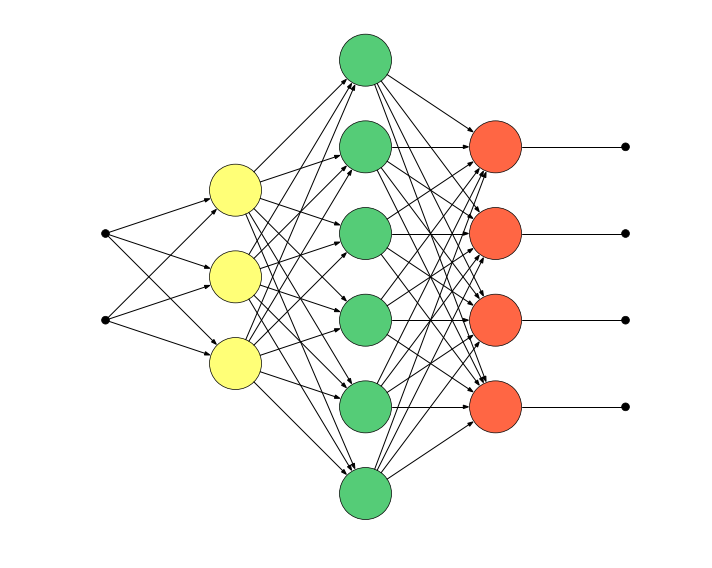

In [222]:
nn.draw(size=(10,8))

In [223]:
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from scipy.interpolate import spline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pylab


class NeuralNetwork:
    """
    
    """
    
    # The layers of the network
    layers = []
    
    def __init__(self, inputs, architecture=[1], lr = 0.01, momentum = 0):
        """
    
        """
        
        # Make sure the architecture is a list and not empty
        assert isinstance(architecture, list) and len(architecture) > 0
        
        # Save the local variables
        self.architecture = architecture
        self.inputs = (int) inputs
        self.momentum = momentum if momentum > 0 else 0
        self.lr = lr if lr > 0 else 0.00001 #make sure the LR is not too close to zero

        # Create the layers and neurons based on the architecture
        self.initLayers()
        
    def initLayers(self)
        """
    
        """
        
        # The amount of inputs of each Neuron need to be the total of neurons of the previus layer OR self.inputs if this is the first layer
        totalInputs = self.inputs
        
        # Clear all layers (and weigths)
        layers = []
        
        # For each layer of the architecture
        for n in architecture:  
            
            # Start an array with the current layer
            currentLayer = []
            
            # Create n neurons 
            for count in range(n):
                currentLayer.append( Neuron(totalInputs, activation='sigmoid') )
                
            totalInputs = n
            
            # Add the current layer to the layer list
            layers.append(currentLayer);
                
    def __str__(self):
        """
        Converte a classe atual em uma string fácil de entender
        """
        return str(self.__class__) + ": " + str(self.__dict__)    
        
        
        
class Neuron:

    def __init__(self, inputs, lr = 0.01):
        
        # Os inputspode ser um array de neuros ou um escalar
        if (isinstance(inputs, list)):
            self.weights = np.random.rand(len(inputs))
        else:
            self.weights = np.random.rand(inputs)
        
        self.bias = 1
        self.inputs = inputs
        self.lr = lr if lr > 0 else 0.0001

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)


    def vj(self, x) :
        if (isinstance(self.inputs, list)):            
            signals = []            
            for i in range(len(self.inputs)):
                signals.append( self.inputs[i].forward(x))             
            return np.dot(self.weights, signals) + self.bias          
        else:
            return np.dot(self.weights, x) + self.bias
        
        
    def forward(self, x):
        return self.activation( self.vj(x) )


    def backward(self, x, y, soma=None): 

        somaPonderada = 0
        
        y_pred = self.forward(x)
        
        for idx in range(len(self.weights)):

            if (soma == None): 
                error = y - y_pred
                gradient = error * self.activation_derivative( self.vj(x) )
            else:
                gradient = self.activation_derivative( self.vj(x) ) * soma
       
            somaPonderada = somaPonderada + gradient*self.weights[idx]
            
            self.weights[idx] = self.weights[idx] + self.lr * x[idx] *  gradient
            
        if (isinstance(self.inputs, list)): 
            for i in range(len(self.inputs)):
                self.inputs[i].backward(x, y, soma=somaPonderada)
            
    def activation(self, x):
        return x

    def activation_derivative(self, x):
        return 1
        
    def adjustWeights(self, x, error):            
        self.bias = self.bias + error*self.lr        
        for idx in range(len(self.weights)):
            self.weights[idx] = self.weights[idx] + error*self.lr*x[idx]

def predict( out):
        """
        Função que discretiza a saída
        Parâmetro: y - saída do neurònio
        """
        if out < 0:
            return 0
        elif out > 7:
            return 7
        else:
            return round(out)
        
# TESTES
X, Y = criaDataset(50, 0.1)   

n_inputs = len(X[0])
        
layer1 = [ Neuron(n_inputs, lr=0.1) , Neuron(n_inputs, lr=0.1)]
    
layer2 = [ Neuron(layer1, lr=0.1)] 

network = layer2

#y_pred = network[0].forward(X[0])
#print(y_pred)

perceptron = network[0]

# perceptron = Neuron(len(X[0]))

print(perceptron)

for epoch in range(10):
    erros_interacao = []
    for i in range(len(X)):
        y_pred = predict( perceptron.forward(X[i]) )
        error = Y[i] - y_pred
        erros_interacao.append(error*error)
        perceptron.backward(X[i], Y[i])
    erro_medio = np.average(erros_interacao)
    print(erro_medio)

# Preenche o array de saidas preditas
y_pred = []
for j in range(len(X)):    
    y_pred.append( predict( perceptron.forward(X[j]) ))
#print(Y, y_pred)
# Métricas de Avaliação
print('Matriz de Confusão:')
print(confusion_matrix(Y, y_pred))
print('F1 Score:')
print(classification_report(Y, y_pred))

SyntaxError: invalid syntax (<ipython-input-223-790b05d6a7ea>, line 30)

### Criação do Perceptron

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import spline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pylab

In [ ]:
def weight_init(num_inputs): 
    """
    Função que inicializa os pesos e bias aleatoriamente utilizando numpy
    Parâmetro: num_inputs - quantidade de entradas X
    Retorna: w,b - pesos e bias da rede inicializados
    """
    w = np.random.rand(num_inputs) - 0.5
    b =  np.random.random() - 0.5       
    return w,b

# Teste da função weight_init:
print(weight_init(5))

In [ ]:
def activation_func(func_type, z):
    """
    Função que implementa as funções de ativação mais comuns
    Parãmetros: func_type - uma string que contém a função de ativação desejada
                z - vetor com os valores de entrada X multiplicado pelos pesos
    Retorna: saída da função de ativação
    """
    if func_type == 'sigmoid':
        return 1/(1 + np.exp(-z))
    elif func_type == 'tanh':
        return math.sinh(z)/math.cosh(z)
    elif func_type == 'relu':
        return 0 if (z<0) else z
    elif func_type == 'linear':
        return z
    elif func_type == 'degrau':
        return 0 if (z < 0) else  1
    
def visualizeActivationFunc(z, func_type):
    pylab.rcParams['figure.figsize'] = (10.0, 5.0)
    z = np.arange(-5., 5., 0.2)
    func = []
    for i in range(len(z)):
        func.append(activation_func(func_type, z[i]))
    
    pylab.rcParams['figure.figsize'] = (5.0, 2.0)
    plt.plot(z,func)
    plt.title("Função: "+func_type)
    plt.xlabel('Entrada')
    plt.ylabel('Valores de Saída')
    plt.show()

# Testa as funções de ativação
visualizeActivationFunc(np.arange(-5., 5., 0.2), 'degrau')
visualizeActivationFunc(np.arange(-5., 5., 0.2), 'sigmoid')
visualizeActivationFunc(np.arange(-5., 5., 0.2), 'tanh')
visualizeActivationFunc(np.arange(-5., 5., 0.2), 'relu')
visualizeActivationFunc(np.arange(-5., 5., 0.2), 'linear')

In [ ]:
def forward(w,b,X):
    """
    Função que implementa a etapa forward propagate do neurônio
    Parâmetros: w - pesos
                b - bias
                X - entradas
    """
    z = np.dot(w,X)+b
    out = activation_func('relu', z)
    return out

# Teste: forward
x = (1, 1, 1)
w,b = weight_init(3)
print("X: ", x)
print("Pesos: ", w)
print("Bias: ", b)
print("Y: ", forward(w,b,x))

In [ ]:
def predict(out):
    """
    Função que discretiza a saída
    Parâmetro: y - saída do neurònio
    """
    if out < 0:
        return 0
    elif out > 7:
        return 7
    else:
        return round(out)

# Teste: predict
print ("Entrada=1.1 -> Saida=", predict(1.1))
print ("Entrada=4.5 -> Saida=", predict(4.5))
print ("Entrada=70.0 -> Saida=", predict(70.0))

In [ ]:
def perceptron(x, y, num_interaction, learning_rate):
    """
    Função que implementa o loop do treinamento 
    Parâmetros: x - entrada da rede 
                y - rótulos/labels
                num_interaction - quantidade de interações desejada para a rede convergir
                learning_rate - taxa de aprendizado para cálculo do erro
    """
    training_interation = []
    training_erro = []
    
    #Passo 1 - Inicie os pesos e bias (~1 linha)
    w,b = weight_init(len(x[0]))
    #Passo 2 - Loop por X interações
    for i in range(num_interaction):
        
        # Ajuda no calculo do erro médio quadrado
        erros_interacao = []
        
        for j in range(len(x)): # para cada exemplo
            
            # Passo 3 -  calcule a saída do neurônio (~1 linha)
            y_calc = predict(forward(w,b,x[j]))
            
            # Passo 4 - calcule o erro entre a saída obtida e a saída desejada nos rótulos/labels (~1 linha)
            erro = y[j] - y_calc  
            
            # Adiciona o erro quadrado dessa instancia
            erros_interacao.append(erro*erro)
            
            # Ajusta os pesos e bias
            for idx in range(len(w)):
                w[idx] = w[idx] + erro*learning_rate*x[j][idx]            

            b = b + erro*learning_rate
        
        # Calcula o erro médio dessa interação
        erro_medio = np.average(erros_interacao)
        
        training_interation.append(i)
        training_erro.append(erro_medio) 
        
        # Apenas para garantir que pare quando o erro atingir um valor limite mínimo
        if (erro_medio < 0.00001):
            print("Finalizado na interação %d visto que o erro médio já se tornou muito pequeno %f" % (i, erro_medio))
            break;
    
    # Cria um grafico com os dados sobre o erro de treinamento
    pylab.rcParams['figure.figsize'] = (15.0, 10.0)
    plt.plot(training_interation, training_erro)
    plt.xlabel('Interação')
    plt.ylabel('Erro médio quadrado')
    plt.show()
    
    return w,b

def validar(w,b,x,y):

    # Preenche o array de saidas preditas
    y_pred = []
    for j in range(len(x)):
        y_pred.append(predict(forward(w,b,x[j])))
       
    # Métricas de Avaliação
    print('Matriz de Confusão:')
    print(confusion_matrix(y, y_pred))
    print('F1 Score:')
    print(classification_report(y, y_pred))


### Criação dos Datasets de Treinamento e Validação

In [ ]:
X_train, Y_train = criaDataset(800, 0.1)
X_val, Y_val = criaDataset(200, 0.1)

### Trainamento do Perceptron

In [ ]:
w, b = perceptron(X_train, Y_train, 1000, 0.001)
print("Pesos Aprendidos:", w, "\nBias Aprendido:", b)

## Resultados

#### Conjunto de Treinamento

In [ ]:
validar(w, b, X_train, Y_train)

#### Conjunto de Validação

In [ ]:
validar(w, b, X_val, Y_val)